<h1 align='center'> Curso de Estadística Bayesiana<br>Tutorial de  Arviz</h1> 

<h3>Autor</h3>

1. Alvaro Mauricio Montenegro Díaz, ammontenegrod@unal.edu.co
2. Daniel Mauricio Montenegro Reyes, dextronomo@gmail.com 

<h3>Fork</h3>

<h3>Referencias</h3>

1. Kumar, Ravin and Carroll, Colin and Hartikainen, Ari and Martin, Osvaldo A., [ArviZ a unified library for exploratory analysis of Bayesian models in Python](https://arviz-devs.github.io/arviz/), [The Journal of Open Source Software](http://joss.theoj.org/papers/10.21105/joss.01143), 2019.

##  Introducción

ESta es una guía rápida de introducción a [Arviz](https://arviz-devs.github.io/arviz/), que es una libería desarrollada para hacer estos análisis en Python. En particular, Arviz puede trabajar cnon las salidas de [Pystan](https://pystan.readthedocs.io/en/latest/) y  [PyMC3](https://docs.pymc.io/), que es un de lenguaje de programación probabilística desarrollado directamente para Python.





In [1]:
# Importamos las librerías requeridas.

import arviz as az
import numpy as np
import pandas as pd
import xarray

# definimos estilos para el fondo de los gráficos y para mostrar la información
az.style.use('arviz-darkgrid')
xarray.set_options(display_style="html");

# Gráficos in line con matplotlib
%matplotlib inline


## Primer plot con Arviz

Aunque Arviz esta diseñado para trabajar con datos provenientes de Pystan y PyMC3, también puede usar array numpy. Como se a continuación.

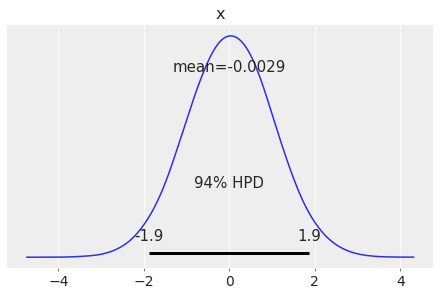

In [2]:
az.plot_posterior(np.random.randn(100_000));

## Dibujamos una matriz de datos

Al dibujar un diccionario de arrays bidimensionales (matrices), ArviZ interpretará cada clave (key) como el nombre de una variable aleatoria diferente. Cada fila de una matriz se trata como una serie independiente de dibujos de la variable, llamada cadena. A continuación, tenemos 10 cadenas de 50 muestras cada una para cuatro distribuciones diferentes.

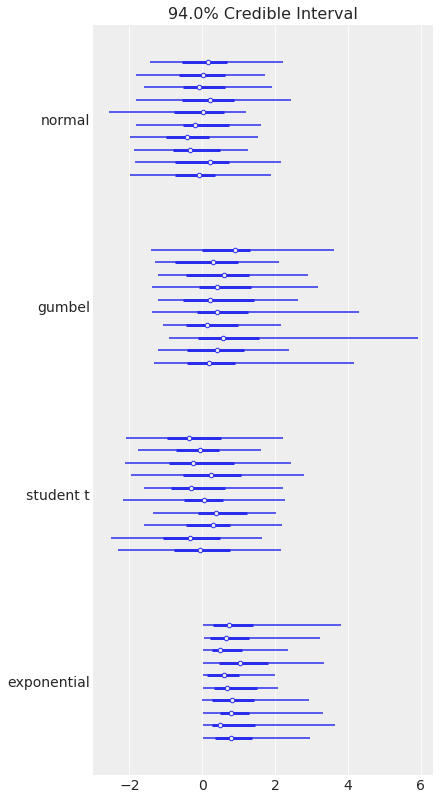

In [3]:
size = (10, 50)
az.plot_forest({
    'normal': np.random.randn(*size),
    'gumbel': np.random.gumbel(size=size),
    'student t': np.random.standard_t(df=6, size=size),
    'exponential': np.random.exponential(size=size)
});

## Gráficos a partir de la salida de Pystan

Creamos el modelo, los datos,compilamos el modelo y obtenemos las muestras. 

In [5]:
import pystan


schools_code = """
data {
  int<lower=0> J;
  real y[J];
  real<lower=0> sigma[J];
}

parameters {
  real mu;
  real<lower=0> tau;
  real theta[J];
}

model {
  mu ~ normal(0, 5);
  tau ~ cauchy(0, 5);
  theta ~ normal(mu, tau);
  y ~ normal(theta, sigma);
}
generated quantities {
    vector[J] log_lik;
    vector[J] y_hat;
    for (j in 1:J) {
        log_lik[j] = normal_lpdf(y[j] | theta[j], sigma[j]);
        y_hat[j] = normal_rng(theta[j], sigma[j]);
    }
}
"""

schools_dat = {'J': 8,
               'y': [28,  8, -3,  7, -1,  1, 18, 12],
               'sigma': [15, 10, 16, 11,  9, 11, 10, 18]}

schools = np.array(['Choate', 'Deerfield', 'Phillips Andover', 'Phillips Exeter',
                    'Hotchkiss', 'Lawrenceville', "St. Paul's", 'Mt. Hermon'])


sm = pystan.StanModel(model_code=schools_code, verbose=False)
fit = sm.sampling(data=schools_dat, iter=1000, chains=4)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_b0eada194ad938e30ed47926216f98ca NOW.


### Densidades Posteriores

Por defecto se señalan los 94% intervalos de credibilidad de más altad densidad, en inglés, high density credibility (HDC).


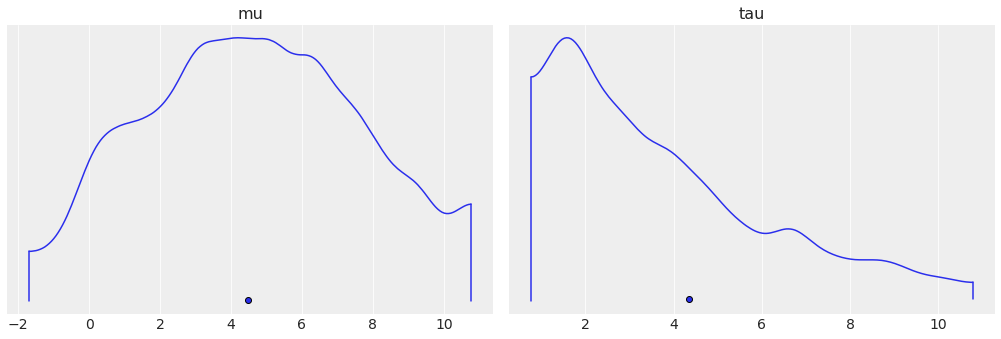

In [6]:
az.plot_density(fit, var_names=['mu', 'tau']);

## Conversión de datos al formato InferenceData

Vamos a covertir los datos de salida de Pystan al formato InferenceData (un almacén de datos netcdf que carga datos en conjuntos de datos de tipo xarray), podemos obtener un etiquetado y una mezcla de datos mucho más ricos. Aquí hay una gráfica que ilustra en dónde la muestra hamiltoniana tuvo divergencias

In [9]:
data = az.from_pystan(
    posterior=fit,
    posterior_predictive='y_hat',
    observed_data=['y'],
    log_likelihood={'y': 'log_lik'},
    coords={'school': schools},
    dims={
        'theta': ['school'],
        'y': ['school'],
        'log_lik': ['school'],
        'y_hat': ['school'],
        'theta_tilde': ['school']
    }
)
data

Inference data with groups:
	> posterior
	> sample_stats
	> log_likelihood
	> posterior_predictive
	> observed_data

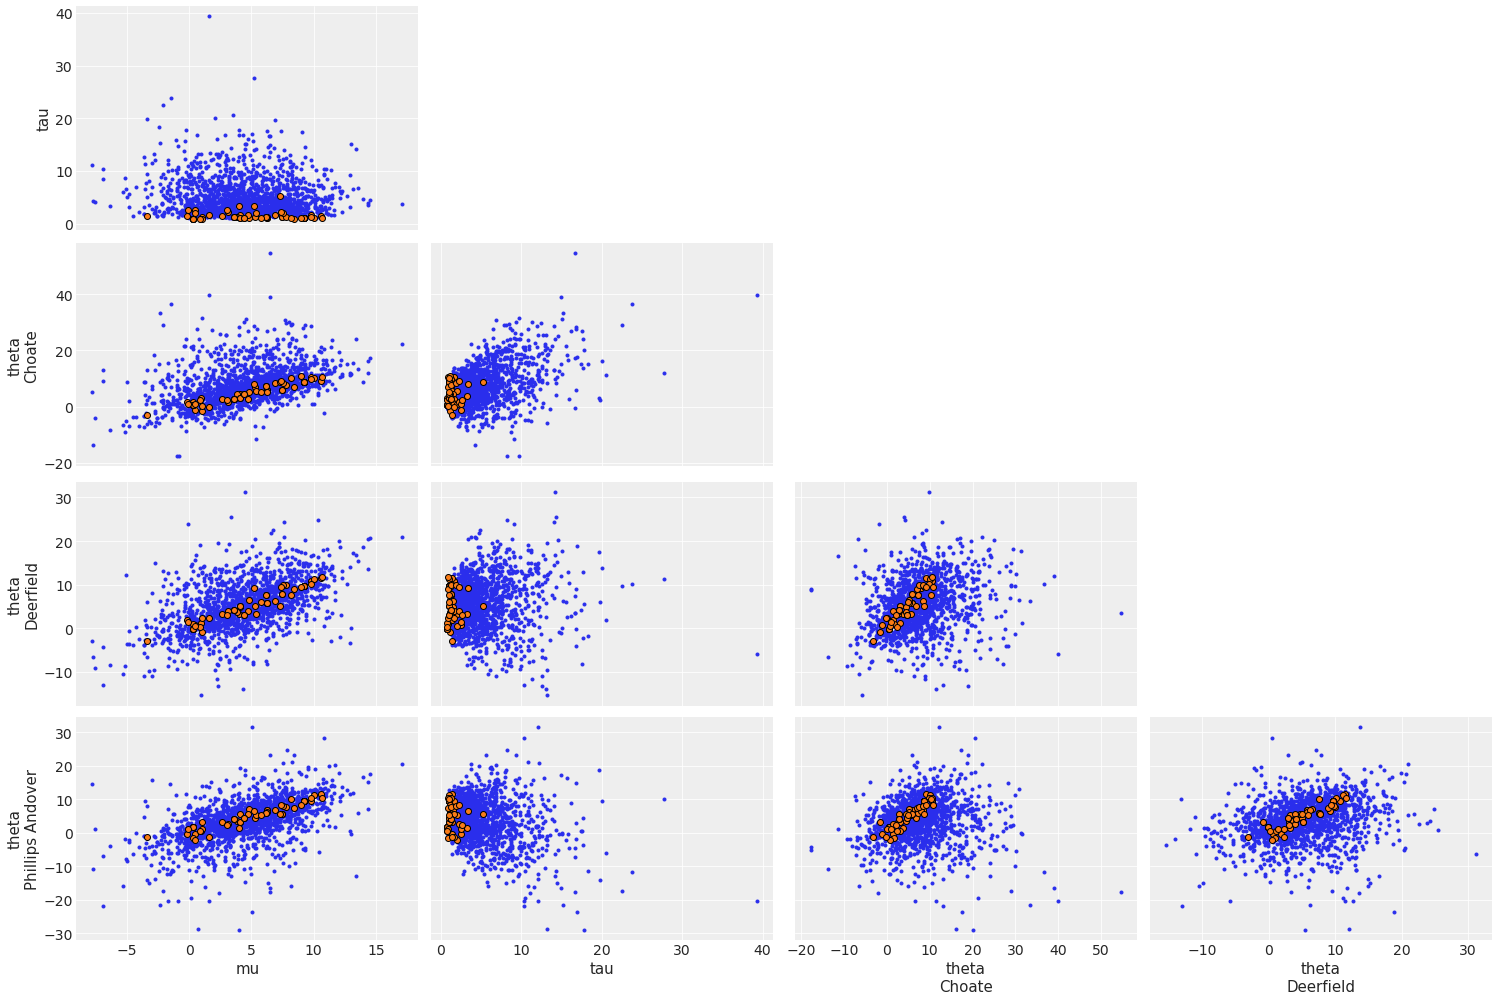

In [10]:
az.plot_pair(data, coords={'school': ['Choate', 'Deerfield', 'Phillips Andover']}, divergences=True);

## El formato de datos InferenceData

InferenceData es el formato de datos central para ArviZ. InferenceData en sí mismo es solo un contenedor que mantiene referencias a uno o más xarray.Dataset. Vea la especificación de la estructura InferenceData aquí. A continuación hay varias formas de generar un objeto InferenceData. Vea aquí para más información sobre xarray.

### Terminología

La terminología utilizada en esta especificación se basa en la terminología de [xarray](http://xarray.pydata.org/en/stable/terminology.html), sin embargo, no se asume ningún conocimiento de xarray en esta descripción. También hay algunas extensiones particulares del caso InferenceData.

1. **Variable**: las variables de tipo NetCDF son matrices multidimensionales etiquetadas que representan una sola cantidad. Las variables y sus dimensiones deben tener nombres. También pueden tener atributos que la describan. Los términos relevantes relacionados con las variables InferenceData son: variable_name, values (sus datos), dimensions, coordinates, and attributes.

2. **Dimensión**: Las dimensiones de un objeto son sus ejes nombrados (etiquetados). Una variable que contiene datos 3D puede tener dimensiones $[chain, draw, dim0]$, por lo tanto, su dimensión 0 es *chain*, su  dimensión 1 es *draw* y así sucesivamente. Cada dimensión presente en una variable InferenceData debe compartir nombres con una coordenada. Dado que las dimensiones deben ser nombradas, la dimensión y el nombre de la dimensión son equivalentes utilizados.

3. **Coordenadas**: un arreglo de nombres que etiqueta dimensiones. Una coordenada denominada *chain* con valores [0, 1, 2, 3] etiquetaría la dimensión *chain*. Los nombres y valores de coordenadas se pueden utilizar de forma flexible como etiquetas y etiquetas de marca a lo largo de una dimensión.

4. **Atributos**: Un diccionario ordenado que puede almacenar metadatos arbitrarios.

5. **Grupo**: conjunto de datos que contiene una o varias variables con un enlace conceptual entre ellas. Las variables dentro de un grupo generalmente también compartirán algunas dimensiones. Por ejemplo, el grupo posterior contiene una representación de la distribución posterior condicionada a las observaciones en el grupo observada_datos.

6. **Muestras coincidentes**: dos variables (o grupos) cuyas muestras coinciden son aquellas que se han generado con el mismo conjunto de muestras. Por lo tanto, compartirán dimensiones y coordenadas correspondientes al proceso de muestreo. Las dimensiones de la muestra (generalmente (chain, draw)) son las introducidas por el proceso de muestreo.

7. **Variables coincidentes**: dos grupos con variables coincidentes son grupos que comparten conceptualmente variables, dimensiones variables y coordenadas de las dimensiones variables, pero no necesariamente comparten nombres de variables ni dimensiones de muestra. Las dimensiones variables son las que son intrínsecas a los datos y al modelo en comparación con las dimensiones de la muestra, que son las relativas al proceso de muestreo. Cuando se habla de variables específicas, esta misma idea se expresa como una variable que es la contraparte de la otra.

## Diseño actual de InferenceData

InferenceData almacena todas las cantidades relevantes para cumplir sus objetivos en diferentes grupos. Los diferentes grupos generalmente distinguen cantidades conceptualmente diferentes en la inferencia Bayesiana, sin embargo, la conveniencia en la creación y uso de objetos InferenceData también juega un papel. En general, cada cantidad (como la distribución posterior o los datos observados) estará representada por varias variables multidimensionales etiquetadas .

Cada grupo debe tener una entrada por variable y cada variable debe tener un nombre. Cuando sea relevante, las dos primeras dimensiones de cada variable deben ser el identificador de la muestra $(chain, draw)$. 

Para grupos como *observe_data* o *constant_data*, estas dos dimensiones iniciales se omiten. Las dimensiones se deben nombrar y compartir el nombre con una coordenada que especifique los valores de índice, llamados valores de coordenadas. Los valores de coordenadas pueden repetirse y no necesariamente deben ser valores numéricos. Las variables no deben compartir nombres con dimensiones.

Además, cada grupo contiene los siguientes atributos:

- *created_at*: la fecha de creación del grupo.

- *inference_library*: la biblioteca utilizada para ejecutar la inferencia.

- *inference_library_version*: versión de la biblioteca de inferencia utilizada.

Los objetos de datos InferenceData contienen cualquier combinación de los grupos que se describen a continuación. Existen algunas relaciones (detalladas a continuación) entre las variables y las dimensiones de los diferentes grupos. Por lo tanto, siempre que haya grupos relacionados presentes, deben cumplir con estas relaciones.

1. **posterior**

Muestras de la distribución posterior $p (\theta | y)$.

2. **sample_stats**

Información y diagnóstico para cada muestra posterior, proporcionada por el backend de inferencia. Puede variar según el algoritmo utilizado por el backend (es decir, una muestra invariante afín no tiene energía asociada). La convención de nombre utilizada para las variables sample_stats es la siguiente:

        - *lp*: (unnormalized) log probability for sample

        - *step_size*: step_size_bar

        - *tune*: boolean variable indicating if the sampler is tuning or sampling

        - *depth*

        - *tree_size*

        - *mean_tree_accept*

        - *diverging*: HMC-NUTS only, boolean variable indicating divergent transitions

        - *energy*: HMC-NUTS only

        - *energy_error*

        - *max_energy_error*

2. **log_likelihood**

Datos de probabilidad de registro puntual. Las muestras deben coincidir con las posteriores y sus variables deben coincidir con las variables observadas_datos. La variable de contraparte observada_datos puede tener un nombre diferente. Además, algunos casos, como una normal multivariada, pueden requerir que algunas dimensiones o coordenadas sean diferentes.

3. **posterior_predictive**

Muestras predictivas posteriores $p (y | y)$ correspondientes a la distribución predictiva posterior evaluada en los datos observados. Las muestras deben coincidir con las posteriores y sus variables deben coincidir con las variables observadas_datos. La variable de contraparte observada_datos puede tener un nombre diferente.


4. **observed_data**

Datos observados en los que el posterior es condicional. Solo debe contener datos modelados como una variable aleatoria. Cada variable debe tener una contraparte en posterior_predictive, sin embargo, la variable de contraparte posterior_predictiva puede tener un nombre diferente.


5. **constant_data**

Constantes de modelo, datos incluidos en el modelo que no están modelados como una variable aleatoria. Deben ser los datos utilizados para generar muestras en todos los grupos, excepto los grupos de predicciones.

6. **prior**

Muestras de la distribución previa $p (\theta)$. Las muestras no necesitan coincidir con las muestras posteriores. Sin embargo, este grupo seguirá la convención sobre la cadena y dibujará como primeras dimensiones. Debe tener variables coincidentes con el grupo posterior.

7. **sample_stats_prior**

Información y diagnóstico para las muestras en el grupo anterior, proporcionado por el backend de inferencia. Puede variar según el algoritmo utilizado por el backend. Los nombres de las variables siguen la misma convención definida en ``sample_stats` <#sample_stats>`_.``

8. **prior_predictive**


Muestras de la distribución predictiva previa. Las muestras deben coincidir con las muestras anteriores y cada variable debe tener una contraparte en posterior_predictive / observe_data.


9. **predictions**

Fuera de la muestra muestras predictivas posteriores $p (y '| y)$. Las muestras deben coincidir con las muestras posteriores. Sus variables deben tener una contraparte en posterior_predictive. Sin embargo, las variables en las predicciones y su contraparte en posterior_predictive pueden tener diferentes valores de coordenadas.

10. **predictions_constant_data**


Las constantes del modelo se utilizan para obtener las muestras de predicciones. Sus variables deben tener una contraparte en constant_data. Sin embargo, las variables en predictions_constant_data y su contraparte en constant_data pueden tener diferentes valores de coordenadas.

## Ejemplo del esquema de InferenceData in Pystan

Vamos a  desarrollar un ejemplo de juguete para ilustrar la implementación del esquema de InferenceData. Es un ejemplo en donde tenemos los datos de desarrolladores de sotfware usanfo Github. 


En el ejemplo *comments* es el número de comentarios que el desarrollador ha hecho en formato slack, *commits* es el número de commits (actualizaciones que ha hecho) y *time* el tempo que lleva en la empresa.

El objetivo es hacer dos regresiones: la primera para predecir comments en función del tiempo y la segunda para predecir commits en función del tiempo.

Así, nuestros dos modelos de regresión son especificados como sigue:


$$
\begin{align}
\text{comments} &\sim \mathcal{N}(b_0 + b_1\times \text{time}, b_{sigma})\\
\text{commits} &\sim \mathcal{N}(c_0 + c_1\times \text{time}, c_{sigma})\\
b_0 &\sim \mathcal{N}(0,200)\\
b_1 &\sim \mathcal{N}(0,200)\\
b_{sigma} &\sim \mathcal{N}(0,300)1_{b_{sigma}>0.0}\\
c_0 &\sim \mathcal{N}(0,10)\\
c_1 &\sim \mathcal{N}(0,10)\\
c_{sigma} &\sim \mathcal{N}(0,300)1_{b_{sigma}>0.0}
\end{align}
$$




In [10]:
# datos de juguete
comments_dict = {'Alice': 7500, 'Bob': 10100, 'Cole':18600, 'Danielle':25200, 'Erika':27500}
commits_dict = {'Alice': 25, 'Bob': 32, 'Cole':49, 'Danielle':66, 'Erika':96}
time_dict = {'Alice': 4.5, 'Bob': 6.0, 'Cole':7.0, 'Danielle':12.0, 'Erika':18.0}
data = pd.DataFrame({'comments': comments_dict, 'commits': commits_dict, 'time': time_dict})

#
time_since_joined = data.time.values
slack_comments = data.comments.values 
github_commits = data.commits.values
names = data.index.values
N = len(names)
data

,comments,commits,time
Alice,7500,25,4.5
Bob,10100,32,6.0
Cole,18600,49,7.0
Danielle,25200,66,12.0
Erika,27500,96,18.0


In [11]:
# data for out of sample predictions
candidate_devs = ["Francis", "Gerard"]
candidate_devs_time = np.array([3.6, 5.1])
N_pred = len(candidate_devs)

In [6]:
# Importamos las librerías requeridas.

import arviz as az
import numpy as np
import pandas as pd
import xarray

# definimos estilos para el fondo de los gráficos y para mostrar la información
az.style.use('arviz-darkgrid')
xarray.set_options(display_style="html");

# Gráficos in line con matplotlib
%matplotlib inline

import pystan

### Generamos muestras a partir de distribuciones a priori

Generamos muestras de las distribciones apriori de los parámetros. A partir de esas muestras y de los valores de la variable tiempo, generamos observaciones para comments y commits.

En esta parte se usan las distribuciones conocidas: normales y normales truncadas. Es decir, ni  el muestreador Hamiltoniano ni el Nouturn no la inferencia variacional son usados. Esto proque en esta parte no hay distribuciones posteriores.

Observe que como no hay un modelo, no hay distribuciones posteriores

Este es el código y su compilación.

In [7]:
linreg_prior_code = """
data {
  int<lower=0> N;
  real time_since_joined[N];
}

generated quantities {
    real b0;
    real b1;
    real log_b_sigma;
    real<lower=0> b_sigma;

    real c0;
    real c1;
    real log_c_sigma;
    real<lower=0> c_sigma;

    vector[N] slack_comments_hat;
    vector[N] github_commits_hat;

    b0 = normal_rng(0,200);
    b1 = normal_rng(0,200);
    b_sigma = abs(normal_rng(0,300));
    log_b_sigma = log(b_sigma);

    c0 = normal_rng(0,10);
    c1 = normal_rng(0,10);
    c_sigma = fabs(normal_rng(0,6));
    log_c_sigma = log(b_sigma);

    for (n in 1:N) {
        slack_comments_hat[n] = normal_rng(b0 + b1 * time_since_joined[n], b_sigma);
        github_commits_hat[n] = normal_rng(c0 + c1 * time_since_joined[n], c_sigma);
    }
}
"""
sm_prior = pystan.StanModel(model_code=linreg_prior_code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_eaf68e1d6159e0b02f4226250c19c7f8 NOW.


### Genera las muestras a priori

Estas mustras las usaremos luego.  

In [12]:
linreg_prior_data_dict = {"N": N, "time_since_joined": time_since_joined}
prior = sm_prior.sampling(data=linreg_prior_data_dict, iter=150, chains=1, algorithm='Fixed_param', warmup=0)

### Código Stan de los modelos y compilación.

Es hora de correr los modelos propuestos. Observe que los dos modelos son corridos simultáneamente.

Vamos a generar de paso algunas cantidades útiles en el análsis Bayesiano descriptivo que son:

1. **log-verosimilitud** (no normalizada) de las observaciones para cada juego de datos: *log_likelihood_slack_comments* y *log_likelihood_github_commits*. Es decir, se genera por cada muestra $\theta^{(k)}$ del parámetro se calcula  $\log p[y_i^{(k)}|\theta^{(k)}], i=1,2,3,4,5$, omitiendo las constantes de normalización.
2. **posterior predictiva**: *log_likelihood_slack_comments* y *log_likelihood_github_commits*. Por cada muestra $\theta^{(k)}$ del parámetro se calcula  $\log p[y_i^{(k)}|y], i=1,2,3,4,5$. Recuerde que en este caso se tiene que $p[y_i|y] = \int p[y_i|\theta] \pi[\theta]d\theta$ Aquí $\pi[\theta]$ es la posterior $\pi[\theta|y]$. Entonces el procedimientos interno es: dado la muestra actual $\theta^{(k)}$ se calcula $\log p[y_i|\theta^{(k)}]$, que es la log-verosimiltud de $y_i$ calculada usando $\theta^{(k)}$. 
3. **predicción de las observaciones**: Se predicen los valores observados usando el modelo de los datos, estos es,  para la variable slack_comments $\hat{y_i} \sim N(b_0^{(k)}  + b_1^{(k)} \times t_i, \sigma_b^{(k)} )$ y para la variable github_commits $\hat{y_i} \sim N(c_0^{(k)}  + c_1^{(k)} \times t_i, \sigma_c^{(k)} )$. 
3. **predicción de datos no observados**: *slack_comments_pred* y *github_commits_pred*. Es el mismo procedimiento del paso anterior, pero aquí se predicen valores no observados. En este caso, si $t_s$ es un valor de la variable tiempo $t$, para el cual no tenemos una observación, y si tal observación la denominamos $\tilde{x}s$, entonces para el caso de la variable *slack_comments* se tiene que $\tilde{x_s} \sim N(b_0^{(k)}  + b_1^{(k)} \times t_s, \sigma_b^{(k)} )$ y para la variable *github_commits* se tiene que $\tilde{x_s} \sim N(c_0^{(k)}  + c_1^{(k)} \times t_s, \sigma_c^{(k)} )$

In [13]:
linreg_code = """
data {
  int<lower=0> N;
  vector<lower=0>[N] time_since_joined;
  vector<lower=0>[N] slack_comments;
  vector<lower=0>[N] github_commits


  // out of sample prediction
  int<lower=0> N_pred;
  vector<lower=0>[N_pred] time_since_joined_pred;
}

parameters {
  real b0;
  real b1;
  real log_b_sigma;

  real c0;
  real c1;
  real log_c_sigma;
}

transformed parameters {
  real<lower=0> b_sigma = exp(log_b_sigma);
  real<lower=0> c_sigma = exp(log_c_sigma);
}

model {
  b0 ~ normal(0,200);
  b1 ~ normal(0,200);
  b_sigma ~ normal(0,300);
  slack_comments ~ normal(b0 + b1 * time_since_joined, b_sigma);
  github_commits ~ normal(c0 + c1 * time_since_joined, c_sigma);

}

generated quantities {
    // elementwise log likelihood
    vector[N] log_likelihood_slack_comments;
    vector[N] log_likelihood_github_commits;

    // posterior predictive
    vector[N] slack_comments_hat;
    vector[N] github_commits_hat;

    // out of sample prediction
    vector[N_pred] slack_comments_pred;
    vector[N_pred] github_commits_pred;

    // posterior predictive
    for (n in 1:N) {
        log_likelihood_slack_comments[n] = normal_lpdf(slack_comments[n] | b0 + b1 * time_since_joined[n], b_sigma);
        slack_comments_hat[n] = normal_rng(b0 + b1 * time_since_joined[n], b_sigma);

        log_likelihood_github_commits[n] = normal_lpdf(github_commits[n] | c0 + c1 * time_since_joined[n], c_sigma);
        github_commits_hat[n] = normal_rng(c0 + c1 * time_since_joined[n], c_sigma);
    }

    // out of sample prediction
    for (n in 1:N_pred) {
        slack_comments_pred[n] = normal_rng(b0 + b1 * time_since_joined_pred[n], b_sigma);
        github_commits_pred[n] = normal_rng(c0 + c1 * time_since_joined_pred[n], c_sigma);
    }
}
"""
sm = pystan.StanModel(model_code=linreg_code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_0383cdc92ef46e93c95d35b9bf7bf0a3 NOW.


### Genera las muestras de las posteriores 

In [17]:
linreg_data_dict = {"N": N, "slack_comments": slack_comments, "github_commits": github_commits, "time_since_joined": time_since_joined, "N_pred" : N_pred, "time_since_joined_pred" : candidate_devs_time}
posterior = sm.sampling(data=linreg_data_dict, iter=1000, chains=4)

### Construye el objeto InferenceData

In [18]:
idata_stan = az.from_pystan(
    posterior=posterior,
    prior=prior,
    posterior_predictive=["slack_comments_hat","github_commits_hat"],
    prior_predictive=["slack_comments_hat","github_commits_hat"],
    observed_data=["slack_comments","github_commits"],
    constant_data=["time_since_joined"],
    log_likelihood={
        "slack_comments": "log_likelihood_slack_comments",
        "github_commits": "log_likelihood_github_commits"
    },
    predictions=["slack_comments_pred", "github_commits_pred"],
    predictions_constant_data=["time_since_joined_pred"],
    coords={"developer": names, "candidate developer" : candidate_devs},
    dims={
        "slack_comments": ["developer"],
        "github_commits" : ["developer"],
        "slack_comments_hat": ["developer"],
        "github_commits_hat": ["developer"],
        "time_since_joined": ["developer"],
        "slack_comments_pred" : ["candidate developer"],
        "github_commits_pred" : ["candidate developer"],
        "time_since_joined_pred" : ["candidate developer"],
    }
)

### Una mirada global

In [19]:
idata_stan

Inference data with groups:
	> posterior
	> sample_stats
	> log_likelihood
	> posterior_predictive
	> observed_data
	> constant_data
	> prior
	> sample_stats_prior
	> prior_predictive
	> predictions
	> predictions_constant_data

In [ ]:
idata_stan.posterior.

In [ ]:
idata_stan.sample_stats

In [ ]:
idata_stan.log_likelihood

In [ ]:
idata_stan.posterior_predictive

In [ ]:
idata_stan.observed_data

In [ ]:
idata_stan.constant_data

In [ ]:
idata_stan.prior

In [ ]:
idata_stan.sample_stats_prior

In [ ]:
idata_stan.prior_predictive

In [ ]:
idata_stan.predictions

In [ ]:
idata_stan.predictions_constant_data

## Plots de Arviz


### Autocorrelogramas

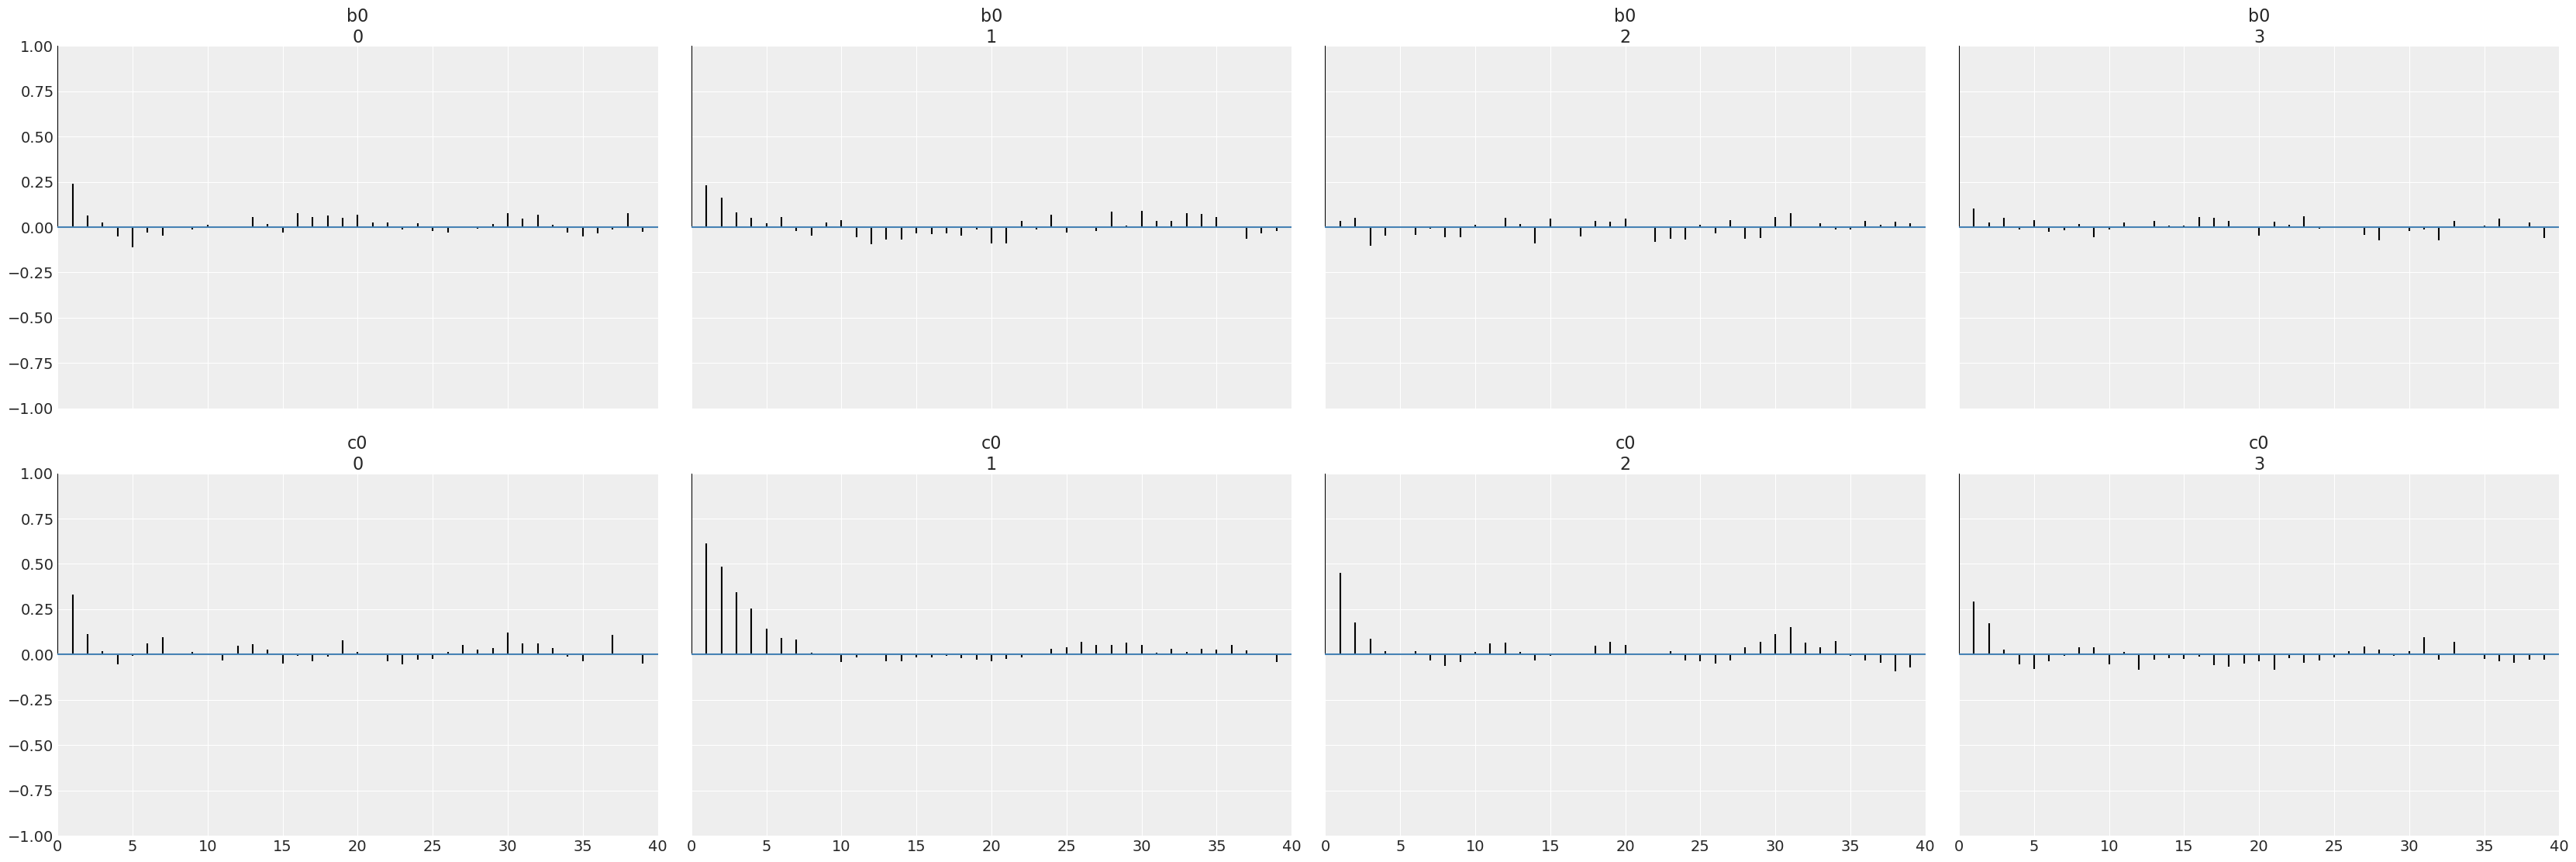

In [24]:
import matplotlib.pyplot as plt
import arviz as az

az.style.use("arviz-darkgrid")

#data = az.load_arviz_data("centered_eight")
az.plot_autocorr(idata_stan, var_names=("b0", "c0"),max_lag=40)
plt.show()

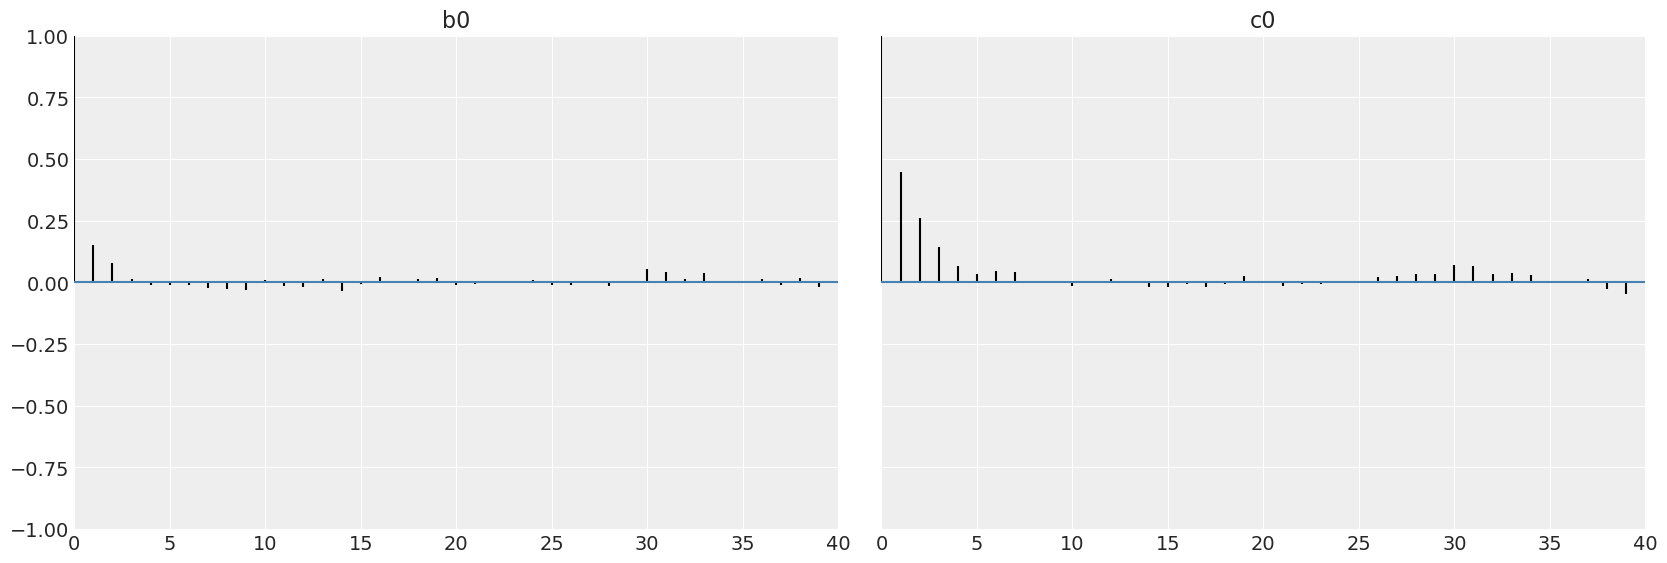

In [25]:
#data = az.load_arviz_data("centered_eight")
az.plot_autocorr(idata_stan, var_names=("b0", "c0"),max_lag=40,combined=True)
plt.show()

In [33]:
az.plot_density?

Signature:
az.plot_density(
    data,
    group='posterior',
    data_labels=None,
    var_names=None,
    transform=None,
    credible_interval=None,
    point_estimate='auto',
    colors='cycle',
    outline=True,
    hpd_markers='',
    shade=0.0,
    bw=4.5,
    figsize=None,
    textsize=None,
    ax=None,
    backend=None,
    backend_kwargs=None,
    show=None,
)
Docstring:
Generate KDE plots for continuous variables and histograms for discrete ones.

Plots are truncated at their 100*(1-alpha)% credible intervals. Plots are grouped per variable
and colors assigned to models.

Parameters
----------
data : Union[Object, Iterator[Object]]
    Any object that can be converted to an az.InferenceData object, or an Iterator returning
    a sequence of such objects.
    Refer to documentation of az.convert_to_dataset for details about such objects.
group: Optional[str]
    Specifies which InferenceData group should be plotted.  Defaults to 'posterior'.
    Alternative values include 'pr

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f14cb2b5590>,
      dtype=object)

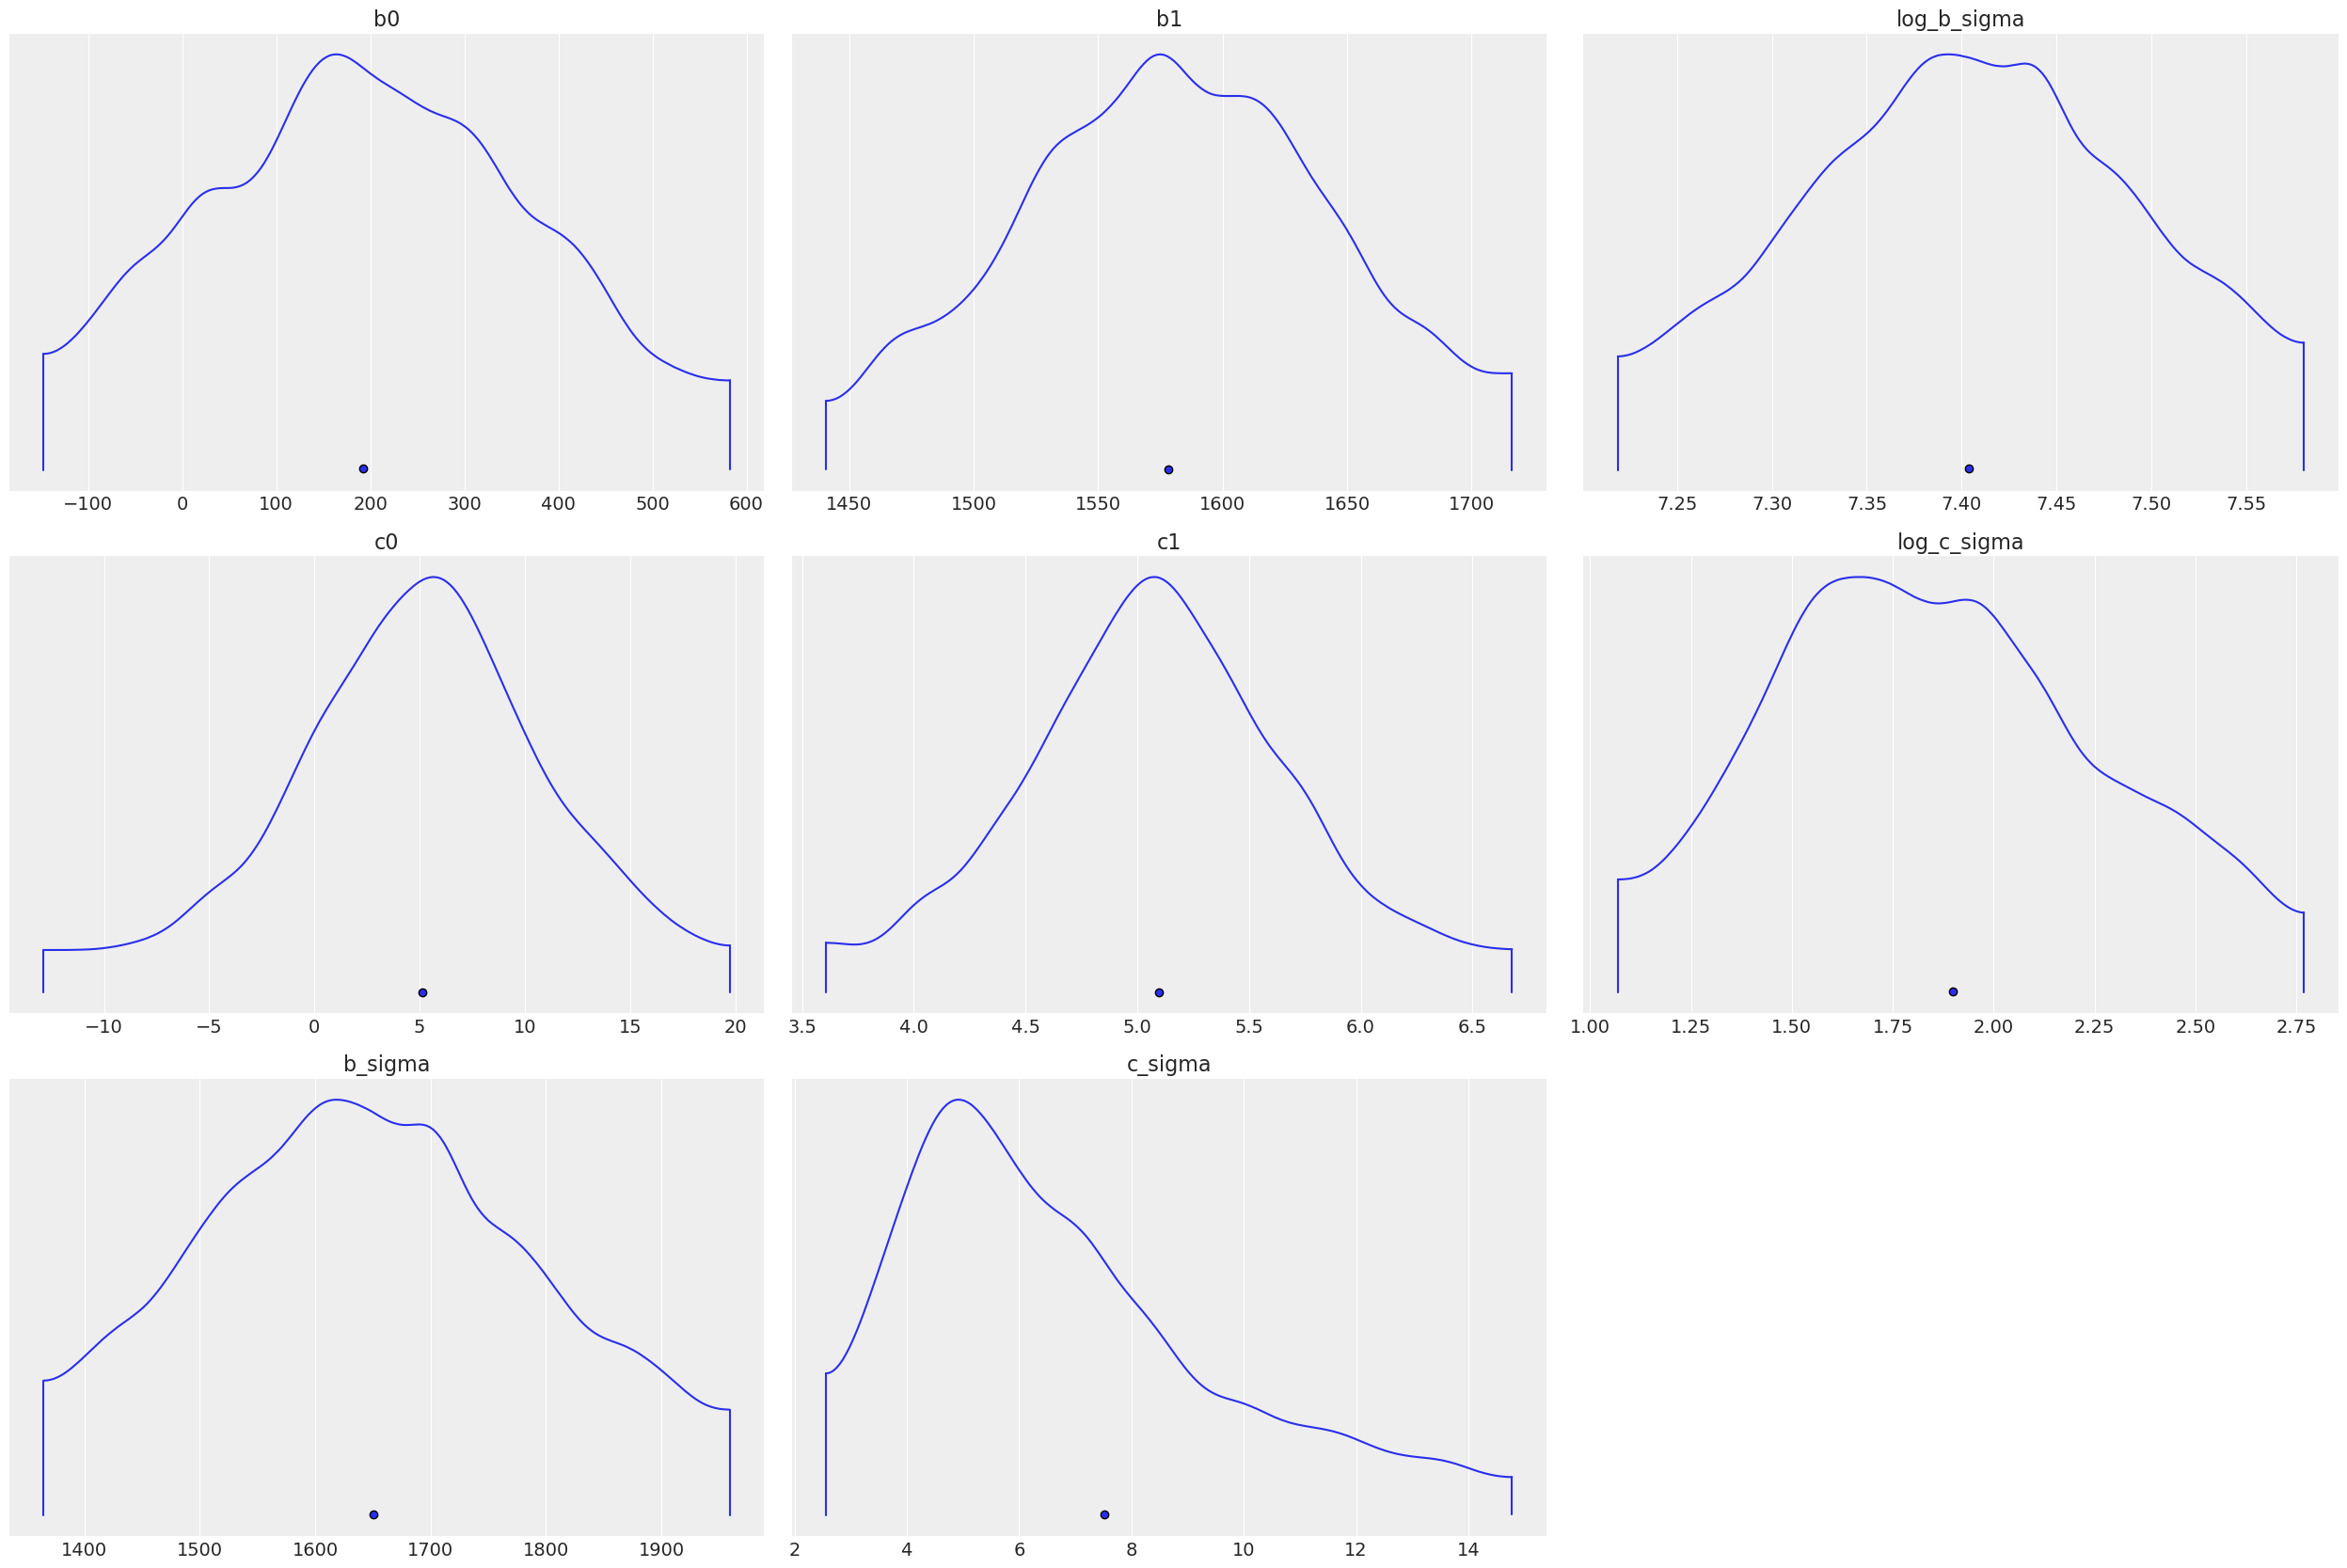

In [38]:
az.plot_density(idata_stan)

###  Evolución del tamaño efectivo de muestra

In [ ]:
az.plot_ess(idata_stan, var_names=["b0"], kind="evolution")

plt.show()

In [ ]:
### Plot forest

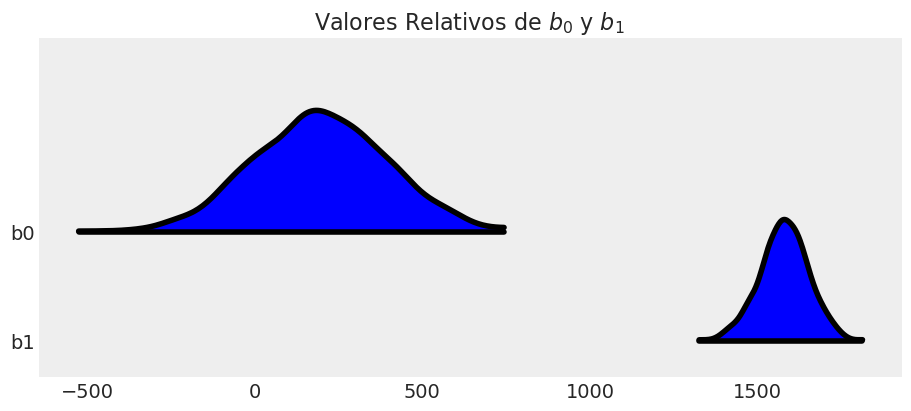

In [46]:
import arviz as az

az.style.use("arviz-darkgrid")

axes = az.plot_forest(
    idata_stan,
    kind="ridgeplot",
    var_names=["b0","b1"],
    linewidth=4,
    combined=True,
    ridgeplot_overlap=1.5,
    colors="blue",
    figsize=(9, 4),
)
axes[0].set_title("Valores Relativos de $b_0$ y $b_1$ ")

plt.show()

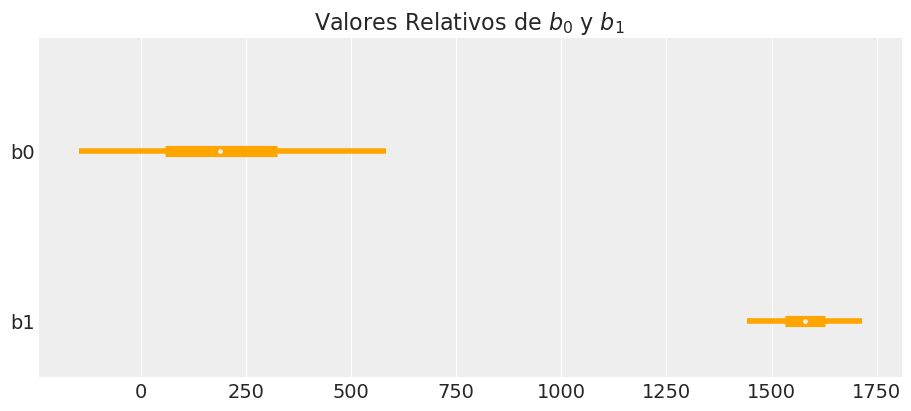

In [48]:
import arviz as az

az.style.use("arviz-darkgrid")

axes = az.plot_forest(
    idata_stan,
    kind="forestplot",
    var_names=["b0","b1"],
    linewidth=4,
    combined=True,
    ridgeplot_overlap=1.5,
    colors="orange",
    figsize=(9, 4),
)
axes[0].set_title("Valores Relativos de $b_0$ y $b_1$ ")

plt.show()

## Tarea

- Calcule la distribución predictiva $p[y_i|y_{-i}]$, en donde $y_{-i}$ es el vector de observaciones omitiendo $y_i$.

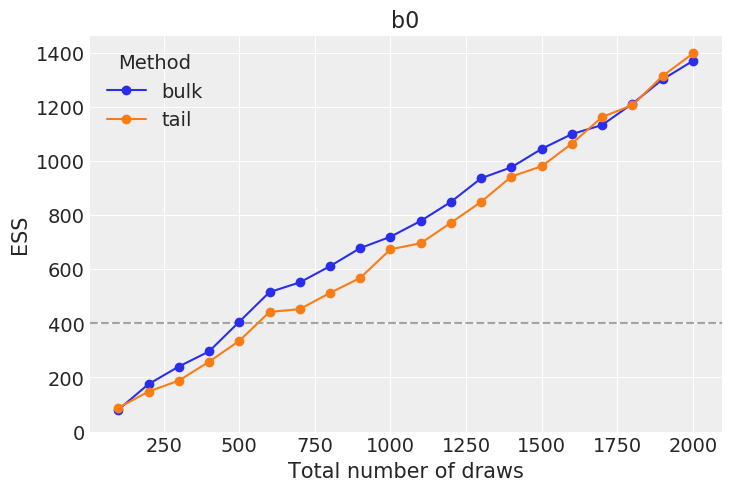

In [39]:
az.plot_ess(idata_stan, var_names=["b0"], kind="evolution")

plt.show()

In [43]:
az.plot_forest?

Signature:
az.plot_forest(
    data,
    kind='forestplot',
    model_names=None,
    var_names=None,
    transform=None,
    coords=None,
    combined=False,
    credible_interval=None,
    rope=None,
    quartiles=True,
    ess=False,
    r_hat=False,
    colors='cycle',
    textsize=None,
    linewidth=None,
    markersize=None,
    ridgeplot_alpha=None,
    ridgeplot_overlap=2,
    ridgeplot_kind='auto',
    ridgeplot_quantiles=None,
    figsize=None,
    ax=None,
    backend=None,
    backend_config=None,
    backend_kwargs=None,
    show=None,
)
Docstring:
Forest plot to compare credible intervals from a number of distributions.

Generates a forest plot of 100*(credible_interval)% credible intervals from
a trace or list of traces.

Parameters
----------
data : obj or list[obj]
    Any object that can be converted to an az.InferenceData object
    Refer to documentation of az.convert_to_dataset for details
kind : str
    Choose kind of plot for main axis. Supports "forestplot" or 

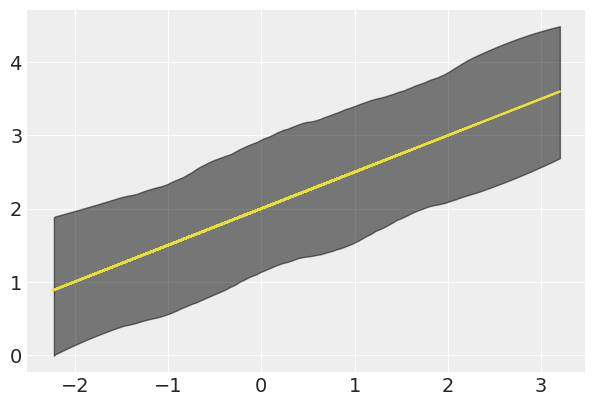

In [54]:
import matplotlib.pyplot as plt
import numpy as np
import arviz as az

az.style.use("arviz-darkgrid")

x_data = np.random.normal(0, 1, 100)
y_data = 2 + x_data * 0.5
y_data_rep = np.random.normal(y_data, 0.5, (200, 100))
plt.plot(x_data, y_data, "C6")
az.plot_hpd(x_data, y_data_rep, color="k", plot_kwargs={"ls": "--"})

plt.show()

### Bandas de confianza

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import arviz as az

az.style.use("arviz-darkgrid")

x_data = np.random.normal(0, 1, 100)
y_data = 2 + x_data * 0.5
y_data_rep = np.random.normal(y_data, 0.5, (200, 100))
plt.plot(x_data, y_data, "C6")
az.plot_hpd(x_data, y_data_rep, color="k", plot_kwargs={"ls": "--"})

plt.show()